In [0]:
# TODO: Experiment with ResNeXT, WideResNet and ResNet-152

In [0]:
! pip install kaggle
! mkdir -p /root/.kaggle
! cp kaggle.json /root/.kaggle/
# ! pip uninstall pillow
# ! pip install pillow

In [0]:
! kaggle competitions download -c padhai-tamil-vowel-consonant-classification

  0% 0.00/145k [00:00<?, ?B/s]
100% 145k/145k [00:00<00:00, 55.0MB/s]
 79% 73.0M/91.9M [00:00<00:00, 107MB/s] 
100% 91.9M/91.9M [00:00<00:00, 145MB/s]
 80% 73.0M/91.6M [00:00<00:00, 88.1MB/s]
100% 91.6M/91.6M [00:00<00:00, 124MB/s] 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
import os
import cv2

In [0]:
train_path = 'train.zip'
test_path = 'test.zip'

with zipfile.ZipFile(train_path, 'r') as zip:
    zip.extractall()

with zipfile.ZipFile(test_path, 'r') as zip:
    zip.extractall()

## Create a PyTorch dataset for the same

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models import inception_v3
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

torch.manual_seed(2019)

In [0]:
def get_transforms(train=False):
    T = []
    if train:
        # Add more transforms here
        # T.append(transforms.RandomVerticalFlip())
        # T.append(transforms.RandomHorizontalFlip())
        T.append(transforms.RandomGrayscale(p=0.3))
    T.append(transforms.Resize((299, 299)))
    T.append(transforms.ToTensor())
    return transforms.Compose(T)

In [0]:
class LangDataset(Dataset):
    def __init__(self, train_dir, transform=None):
        self.images = []
        self.targets = []  # Stores the target in the form of (vowel, consonant)
        self.transform = transform

        images = os.listdir(train_dir)
        for image in tqdm(images):
            image_path = os.path.join(train_dir, image)
            img = Image.open(image_path).convert('RGB')
            self.images.append(img)
            target, _ = os.path.splitext(image)
            vowel, consonant = target.split('_')[:2]
            vowel_idx = int(vowel[1])
            consonant_idx = int(consonant[1])

            self.targets.append(torch.as_tensor([vowel_idx, consonant_idx], dtype=torch.long))

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        if self.transform:
            image = self.transform(image)
        return image, target

    def __len__(self):
        return len(self.images)

In [0]:
train_dir = '/content/train/'

# Sanity check the dataset
transform = get_transforms(train=True)
dataset = LangDataset(train_dir, transform=transform)

100%|██████████| 10000/10000 [00:04<00:00, 2218.20it/s]


tensor([9, 1])


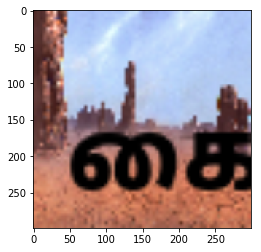

In [0]:
img, label = dataset[0]
plt.imshow(img.permute(1, 2, 0))
print(label)

## Define the model

In [0]:
inception_net = inception_v3(pretrained=True, aux_logits=False)
for name, module in inception_net.named_parameters():
    print(name)

Conv2d_1a_3x3.conv.weight
Conv2d_1a_3x3.bn.weight
Conv2d_1a_3x3.bn.bias
Conv2d_2a_3x3.conv.weight
Conv2d_2a_3x3.bn.weight
Conv2d_2a_3x3.bn.bias
Conv2d_2b_3x3.conv.weight
Conv2d_2b_3x3.bn.weight
Conv2d_2b_3x3.bn.bias
Conv2d_3b_1x1.conv.weight
Conv2d_3b_1x1.bn.weight
Conv2d_3b_1x1.bn.bias
Conv2d_4a_3x3.conv.weight
Conv2d_4a_3x3.bn.weight
Conv2d_4a_3x3.bn.bias
Mixed_5b.branch1x1.conv.weight
Mixed_5b.branch1x1.bn.weight
Mixed_5b.branch1x1.bn.bias
Mixed_5b.branch5x5_1.conv.weight
Mixed_5b.branch5x5_1.bn.weight
Mixed_5b.branch5x5_1.bn.bias
Mixed_5b.branch5x5_2.conv.weight
Mixed_5b.branch5x5_2.bn.weight
Mixed_5b.branch5x5_2.bn.bias
Mixed_5b.branch3x3dbl_1.conv.weight
Mixed_5b.branch3x3dbl_1.bn.weight
Mixed_5b.branch3x3dbl_1.bn.bias
Mixed_5b.branch3x3dbl_2.conv.weight
Mixed_5b.branch3x3dbl_2.bn.weight
Mixed_5b.branch3x3dbl_2.bn.bias
Mixed_5b.branch3x3dbl_3.conv.weight
Mixed_5b.branch3x3dbl_3.bn.weight
Mixed_5b.branch3x3dbl_3.bn.bias
Mixed_5b.branch_pool.conv.weight
Mixed_5b.branch_pool.bn.weig

In [0]:
class CharacterClassifier(nn.Module):
    def __init__(self, num_vowels, num_consonants):
        super().__init__()
        self.vowel_output = nn.Linear(in_features=2048, out_features=num_vowels)
        self.consonants_output = nn.Linear(in_features=2048, out_features=num_consonants)
        self.output = nn.LogSoftmax(dim=1)

        self.inception_net = inception_v3(pretrained=True, aux_logits=False)
        del self.inception_net.fc

        for name, param in self.inception_net.named_parameters():
            if name == 'Mixed_5b.branch3x3dbl_1.conv.weight':
                break
            param.requires_grad = False

    def forward(self, input):
        x = input
        for name, module in self.inception_net.named_children():
            if name == 'Conv2d_2b_3x3':
                x = self.inception_net.Conv2d_2b_3x3(x)
                x = F.max_pool2d(x, kernel_size=3, stride=2)
                continue

            if name == 'Conv2d_4a_3x3':
                x = self.inception_net.Conv2d_4a_3x3(x)
                x = F.max_pool2d(x, kernel_size=3, stride=2)
                continue
            x = module(x)
        # Adaptive average pooling for inceptionV3
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 2048 x 1 x 1
        x = F.dropout(x, training=self.training)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        v_out = self.output(self.vowel_output(x))
        c_out = self.output(self.consonants_output(x))

        return v_out, c_out

In [0]:
num_vowels = 13
num_consonants = 19
lr = 0.001
batch_size = 64
log_step = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
# Create the train and the validation set
num_items = len(dataset)
test_split = 0.05
val_split = 0.05
num_train_samples = int((1 - (test_split + val_split)) * num_items)
num_test_samples = int(test_split * num_items)
num_val_samples = int(val_split * num_items)
train_dataset, val_dataset, test_dataset = random_split(dataset, [num_train_samples, num_val_samples, num_test_samples])

train_loader = DataLoader(train_dataset, num_workers=4, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, num_workers=4, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, num_workers=4, shuffle=True, batch_size=num_test_samples)

In [0]:
criterion = nn.NLLLoss()
classifier = CharacterClassifier(num_vowels, num_consonants).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [0]:
# Sanity check the classifier
sample_batch, targets_batch = next(iter(train_loader))
sample_batch = sample_batch.cuda()
targets_batch = targets_batch.cuda()
v_out, c_out = classifier(sample_batch)

In [0]:
def train_one_epoch(model, criterion, optimizer, val_batch, val_targets, log_step=50):
    loss_profile = []
    for idx, (input_batch, target_batch) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()

        input_batch = input_batch.cuda()
        target_batch = target_batch.cuda()
        v_out, c_out = model(input_batch)

        # compute the vowel loss
        vowel_targets = target_batch[:, 0]
        consonant_targets = target_batch[:, 1]
        v_loss = criterion(v_out, vowel_targets)
        c_loss = criterion(c_out, consonant_targets)

        loss = v_loss + c_loss
        # compute the gradients
        loss.backward()

        # optimize the parameters
        optimizer.step()

        if idx % log_step == 0:
            # evaluate the model
            model.eval()
            v_val_out, c_val_out = model(val_batch)
            val_loss = criterion(v_val_out, val_targets[:, 0]) + criterion(c_val_out, val_targets[:, 1])
            print(f'StepIdx: {idx} V_loss: {v_loss.item()} C_loss: {c_loss.item()} Loss: {loss.item()} ValLoss: {val_loss}')
            torch.save(model.state_dict(), 'classifier.pt')
        loss_profile.append(loss.item())
    return loss_profile

In [0]:
loss_profile = []
num_epochs = 5
val_batch, val_targets = next(iter(val_loader))
val_batch = val_batch.to(device)
val_targets = val_targets.to(device)

load_pretrained_model = False

In [0]:
if load_pretrained_model:
    classifier.load_state_dict(torch.load('classifier.pt'))
for epoch_idx in range(num_epochs):
    print(f'Epoch Idx: {epoch_idx}')
    loss = train_one_epoch(classifier, criterion, optimizer, val_batch, val_targets, log_step=log_step)
    loss_profile.extend(loss)

Epoch Idx: 0
StepIdx: 0 V_loss: 0.045982446521520615 C_loss: 0.05173477530479431 Loss: 0.09771722555160522 ValLoss: 0.36778390407562256
StepIdx: 50 V_loss: 0.014129236340522766 C_loss: 0.050920143723487854 Loss: 0.06504938006401062 ValLoss: 0.4195408821105957
StepIdx: 100 V_loss: 0.018285810947418213 C_loss: 0.048821017146110535 Loss: 0.06710682809352875 ValLoss: 0.25683483481407166
Epoch Idx: 1
StepIdx: 0 V_loss: 0.0012197718024253845 C_loss: 0.033687204122543335 Loss: 0.03490697592496872 ValLoss: 0.2739950120449066
StepIdx: 50 V_loss: 0.0651804581284523 C_loss: 0.055630169808864594 Loss: 0.1208106279373169 ValLoss: 0.2672387361526489
StepIdx: 100 V_loss: 0.0796121209859848 C_loss: 0.011637747287750244 Loss: 0.09124986827373505 ValLoss: 0.18115946650505066
Epoch Idx: 2
StepIdx: 0 V_loss: 0.010843463242053986 C_loss: 0.0020058229565620422 Loss: 0.012849286198616028 ValLoss: 0.31026071310043335
StepIdx: 50 V_loss: 0.00621892511844635 C_loss: 0.009755127131938934 Loss: 0.0159740522503852

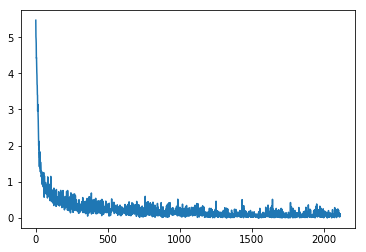

In [0]:
plt.plot(loss_profile)

## Evaluation

In [0]:
def get_predictions(model, test_samples):
    model.eval()
    v_out, c_out = model(test_samples)
    vowel_pred = torch.topk(v_out, 1, dim=1)
    consonant_pred = torch.topk(c_out, 1, dim=1)
    return vowel_pred.indices, consonant_pred.indices

In [0]:
# test_samples, test_targets = next(iter(test_loader))
# test_samples = test_samples.cuda()
# test_targets = test_targets.cuda()
def compute_accuracy(dataset, model):
    num_correct = 0
    total_samples = len(dataset)
    for sample, target in tqdm(dataset):
        sample = torch.unsqueeze(sample, 0).cuda()
        v_pred, c_pred = get_predictions(model, sample)
        if v_pred.item() == target[0].item() and c_pred.item() == target[1].item():
            num_correct += 1
    accuracy = num_correct / total_samples
    return accuracy

In [0]:
accuracy = compute_accuracy(test_dataset, classifier)
print(accuracy)

100%|██████████| 500/500 [00:17<00:00, 27.86it/s]

0.946


In [0]:
import pandas as pd

test_image = os.listdir('/content/test/')
transform = get_transforms(train=False)
cols = ['ImageId', 'Class']
test_df = pd.DataFrame(columns=cols)
for image in tqdm(test_image):
    image_path = os.path.join('/content/test', image)
    img = transform(Image.open(image_path).convert('RGB'))
    img = torch.unsqueeze(img, 0).cuda()
    data = {}
    data['ImageId'] = image
    v_pred, c_pred = get_predictions(classifier, img)
    data['Class'] = f'V{v_pred.item()}_C{c_pred.item()}'
    test_df = test_df.append(data, ignore_index=True)

100%|██████████| 10000/10000 [06:19<00:00, 26.38it/s]


In [0]:
test_df.to_csv('pred_results.csv', index=False)

In [0]:
test_df.head()

,ImageId,Class
0,2018.png,V2_C0
1,9845.png,V9_C8
2,2820.png,V2_C8
3,4533.png,V4_C5
4,9638.png,V9_C6
